### Playground

This is a quick and dirty test to look at the singular values and try LDA

In [1]:
%run settings.py

In [6]:
tf_vecs = pickle.load(open('data/tf_vecs.pkl', 'rb'))
tfidf_corpus = pickle.load(open('data/tfidf_corpus.pkl', 'rb'))
id2word_tf = pickle.load(open('data/id2word_tf.pkl', 'rb'))

cv_vecs = pickle.load(open('data/cv_vecs.pkl', 'rb'))
tfidf_corpus = pickle.load(open('data/cv_corpus.pkl', 'rb'))
id2word_tf = pickle.load(open('data/id2word.pkl', 'rb'))

In [3]:
def Trunc_SVD(vecs, n_components=300, iterations=1, normalize=False, random_state=42):
    """
    Performs LSA on a sparse document term matrix, returns a fitted, transformed, (normalized) LSA object
    """

    # Initialize SVD object as LSA
    lsa = TruncatedSVD(n_components=n_components, n_iter=iterations, 
                       algorithm='randomized', random_state=random_state)
    dtm_lsa = lsa.fit(vecs)
    print("Explained Variance - LSA {}:".format(n_components), dtm_lsa.explained_variance_ratio_.sum())
    if normalize:
        dtm_lsa_t = lsa.fit_transform(vecs)
        dtm_lsa_t = Normalizer(copy=False).fit_transform(dtm_lsa_t)
        return dtm_lsa, dtm_lsa_t
    return dtm_lsa


def plot_SVD(lsa, title, level=None):
    """
    Plots the singular values of an LSA object
    """
    plt.figure(num=1, figsize=(15,10))
    plt.suptitle(title, fontsize=22, x=.55, y=.45, horizontalalignment='left')
    plt.subplot(221)
    plt.title('Explained Variance by each Singular Value')
    plt.plot(lsa.explained_variance_[:level])
    
    plt.subplot(222)
    plt.title('Explained Variance Ratio by each Singular Value')
    plt.plot(lsa.explained_variance_ratio_[:level])
    
    plt.subplot(223)
    plt.title("Singular Values ('Components')")
    plt.plot(lsa.singular_values_[:level])
    plt.show()

Explained Variance - LSA 500: 0.4665874101563385


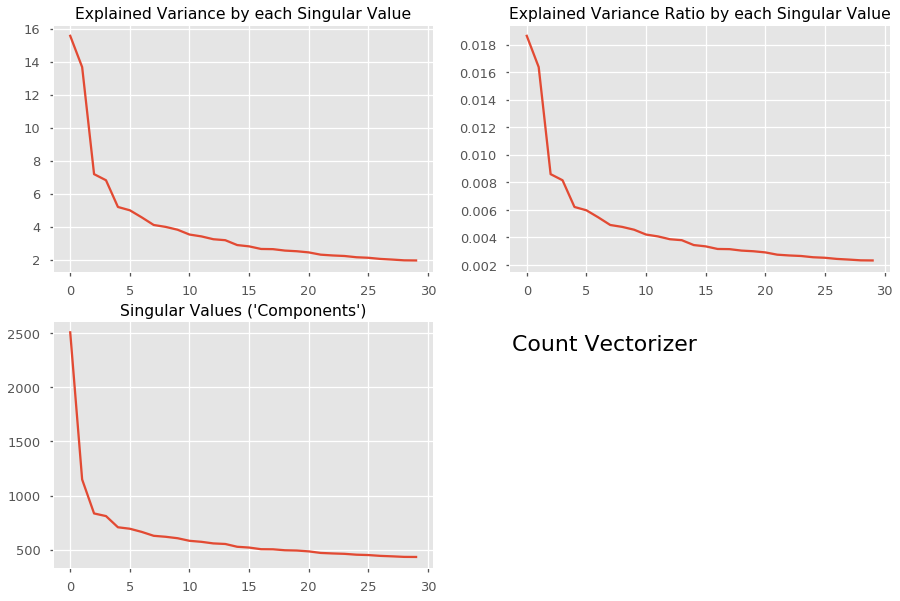

Explained Variance - LSA 500: 0.15858401313499998


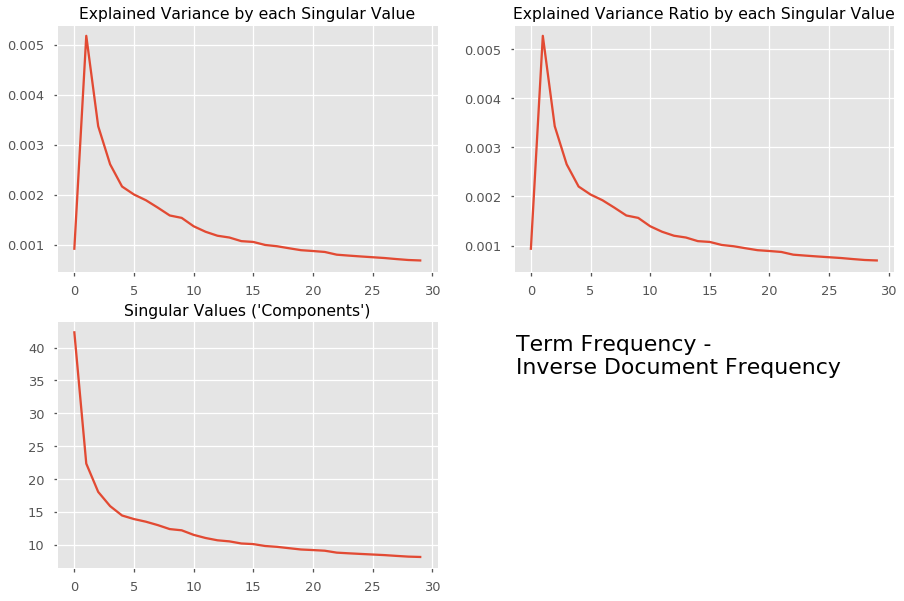

CPU times: user 14min 13s, sys: 2min 35s, total: 16min 48s
Wall time: 9min 25s


In [7]:
%%time
components = 500
cv_dtm = Trunc_SVD(cv_vecs, n_components=components, iterations=5, normalize=False)
plot_SVD(cv_dtm, title='Count Vectorizer', level=30)

tf_dtm = Trunc_SVD(tf_vecs, n_components=components, iterations=5, normalize=False)
plot_SVD(tf_dtm, title='Term Frequency - \nInverse Document Frequency', level=30)

In [8]:
cv_evr = cv_dtm.explained_variance_ratio_
tf_evr = tf_dtm.explained_variance_ratio_

def print_evr(evr, top=2):
    return round(sum(list(evr[:top])),3)

# Numerically confirming the elbow in the above plot
print('SVD Value| CV | TFIDF')
print('Top 2:\t', print_evr(cv_evr,2), print_evr(tf_evr,2))
print('Top 3:\t', print_evr(cv_evr,3), print_evr(tf_evr,3))
print('Top 4:\t', print_evr(cv_evr,4), print_evr(tf_evr,4))
print('Top 5:\t', print_evr(cv_evr,5), print_evr(tf_evr,5))
print('Top 6:\t', print_evr(cv_evr,6), print_evr(tf_evr,6))
print('Top 7:\t', print_evr(cv_evr,7), print_evr(tf_evr,7))
print('Top 8:\t', print_evr(cv_evr,8), print_evr(tf_evr,8))
print('Top 16:\t', print_evr(cv_evr,16), print_evr(tf_evr,16))
print('Top 32:\t', print_evr(cv_evr,32), print_evr(tf_evr,32))
print('Top 64:\t', print_evr(cv_evr,64), print_evr(tf_evr,64))
print('Top 128:', print_evr(cv_evr,128), print_evr(tf_evr,128))
print('Top 256:', print_evr(cv_evr,256), print_evr(tf_evr,256))
print('Top 350:', print_evr(cv_evr,350), print_evr(tf_evr,350))
print('Top 500:', print_evr(cv_evr,500), print_evr(tf_evr,500))

SVD Value| CV | TFIDF
Top 2:	 0.035 0.006
Top 3:	 0.044 0.01
Top 4:	 0.052 0.012
Top 5:	 0.058 0.014
Top 6:	 0.064 0.017
Top 7:	 0.069 0.018
Top 8:	 0.074 0.02
Top 16:	 0.106 0.031
Top 32:	 0.149 0.044
Top 64:	 0.207 0.06
Top 128: 0.283 0.084
Top 256: 0.374 0.117
Top 350: 0.418 0.135
Top 500: 0.467 0.159


In [14]:
%%time
lda = models.LdaMulticore(corpus=tfidf_corpus, num_topics=7, id2word=id2word_tf, passes=40, 
                          workers=7, random_state=42, eval_every=None, chunksize=2000)

CPU times: user 2h 47min 41s, sys: 9min 31s, total: 2h 57min 13s
Wall time: 2h 54min 36s


In [15]:
# Gensim save
#lda.save('data/gensim_lda.model')
#lda =  models.LdaModel.load('data/gensim_lda.model')

In [16]:
%%time
# Transform the docs from the word space to the topic space (like "transform" in sklearn)
lda_corpus = lda[tfidf_corpus]

# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_corpus]

CPU times: user 1min 31s, sys: 1.78 s, total: 1min 33s
Wall time: 1min 30s


In [17]:
import pyLDAvis.gensim

# Enables visualization in jupyter notebook
pyLDAvis.enable_notebook()

# Prepare the visualization
# Change multidimensional scaling function via mds parameter
# Options are tsne, mmds, pcoa 
# cv_corpus or cv_vecs work equally
viz = pyLDAvis.gensim.prepare(topic_model=lda, corpus=tfidf_corpus, dictionary=id2word_tf, mds='mmds')

# Save the html for sharing!
#pyLDAvis.save_html(viz,'data/viz.html')

# Interact! Saliency is the most important metric that changes the story of each topic.
pyLDAvis.display(viz)